In [1]:
import sys

import torch
from torch.utils.data import DataLoader
from transformers import AutoConfig, AutoProcessor, AutoTokenizer

sys.path.append("/home/fock/code/MultiModalInstructERC")
import os

import numpy as np
from peft import PeftModel

from utils import (
    MeldDataset,
    MmLlamaConcat,
    MmLlamaConfig,
    MmLlamaProcessor,
    SequenceClassificationCollator,
)

In [2]:
LANGUAGE_MODEL = "/home/fock/code/MultiModalInstructERC/models/language/LLaMA2"
LORA_ADAPTER = "/home/fock/code/MultiModalInstructERC/models/language/adapter/meld/LLaMA2"
ACOUSTIC_MODEL = "/home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim"
DS_TRAIN_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/train_sent_emo.csv"
DS_DEV_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/dev_sent_emo.csv"
DS_TEST_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/test_sent_emo.csv"

STAGE1_PATH = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/concat/interpolate/stage_1"
STAGE2_PATH = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/concat/interpolate/stage_2"

In [3]:
llm_config = AutoConfig.from_pretrained(LANGUAGE_MODEL)
ac_config = AutoConfig.from_pretrained(ACOUSTIC_MODEL)
ac_processor = AutoProcessor.from_pretrained(ACOUSTIC_MODEL)

# setup of tokenizer
tokenizer = AutoTokenizer.from_pretrained(LANGUAGE_MODEL)
tokenizer.add_special_tokens({"additional_special_tokens": ["<audio>"]})
tokenizer.pad_token_id = tokenizer.unk_token_id
tokenizer.padding_side = "left"

# setup of processor
processor = MmLlamaProcessor(ac_processor, tokenizer)

## setup of config
audio_token_id = tokenizer.additional_special_tokens_ids[0]
config = MmLlamaConfig(
    llm_config, ac_config, audio_token_id, tokenizer.pad_token_id, LORA_ADAPTER
)

model = MmLlamaConcat(config, output_attention_weights=True)
model = PeftModel.from_pretrained(model, STAGE2_PATH, is_trainable=False)
model = model.merge_and_unload(progressbar=True)
model.load_state_dict(torch.load(os.path.join(STAGE1_PATH, "best_model.pth")))
model = model.to("cuda")
# model = PeftModel.from_pretrained(model, args.output_path, is_trainable=False)
# model = model.merge_and_unload(progressbar=True)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Unloading and merging model: 100%|██████████| 550/550 [00:03<00:00, 163.69it/s]
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at /home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Unloading and merging model: 100%|██████████| 813/813 [00:04<00:00, 187.96it/s]


In [4]:
test_dataset = MeldDataset(DS_TEST_PATH, mode="test", task="normal", include_target_text_percentage=1)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    collate_fn=SequenceClassificationCollator(processor, mode="dev"),
)

sample = next(iter(test_dataloader))[0]
sample

{'text': {'input_ids': tensor([[    1,  2567,   366,   526, 17924,   310, 19688,   322, 23023,  1848,
           7418, 29889,   450,  1494, 14983, 11682,  1546,   525,  2277, 29937,
            835, 29915, 20789,  3196, 25657, 29889,   835,  5013,  5790, 29918,
          29900, 29901,   376, 11008,   437,   599,   366, 30341,   276, 26935,
            286, 16926,   505,  3694,   373,   278,  5970,  3026,   835,  3529,
           1831,   278, 23023,  1848,  3858,   310,   529, 10649,  5790, 29918,
          29900, 29901, 29871, 32000,   376, 11008,   437,   599,   366, 30341,
            276, 26935,   286, 16926,   505,  3694,   373,   278,  5970, 29973,
           1013,   515,   529,  7610,  7734, 29892, 27343, 29892, 21104, 29892,
          15331, 29892, 14610,  2264, 29892,  8866, 29892,   766, 29887,   504,
          23917]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [5]:
a_encoder = model.wave2vec2
projector = model.projector.half()

def prepare_batch(batch:dict[torch.Tensor]):
    batch = {k: v.half().to("cuda") for k, v in batch.items()}
    return batch

with torch.no_grad():
    a_output = a_encoder(**prepare_batch(sample["acoustic"])).last_hidden_state
    a_output = projector(a_output)

a_output

tensor([[[ 0.0045,  0.0334,  0.0416,  ...,  0.0084,  0.0120, -0.0456],
         [ 0.0097,  0.0343,  0.0393,  ...,  0.0089,  0.0545, -0.0494],
         [-0.0092,  0.0337,  0.0580,  ...,  0.0087,  0.0405, -0.0247],
         ...,
         [-0.0338,  0.0343,  0.0005,  ...,  0.0723,  0.0317,  0.0013],
         [-0.0434,  0.0411,  0.0102,  ...,  0.0637,  0.0499, -0.0240],
         [-0.0393,  0.0335,  0.0273,  ...,  0.0328,  0.0305, -0.0394]]],
       device='cuda:0', dtype=torch.float16)

In [6]:
for i, (name, _) in enumerate(model.named_modules()):
    print(i, name)

0 
1 llama
2 llama.model
3 llama.model.embed_tokens
4 llama.model.layers
5 llama.model.layers.0
6 llama.model.layers.0.self_attn
7 llama.model.layers.0.self_attn.q_proj
8 llama.model.layers.0.self_attn.k_proj
9 llama.model.layers.0.self_attn.v_proj
10 llama.model.layers.0.self_attn.o_proj
11 llama.model.layers.0.self_attn.rotary_emb
12 llama.model.layers.0.mlp
13 llama.model.layers.0.mlp.gate_proj
14 llama.model.layers.0.mlp.up_proj
15 llama.model.layers.0.mlp.down_proj
16 llama.model.layers.0.mlp.act_fn
17 llama.model.layers.0.input_layernorm
18 llama.model.layers.0.post_attention_layernorm
19 llama.model.layers.1
20 llama.model.layers.1.self_attn
21 llama.model.layers.1.self_attn.q_proj
22 llama.model.layers.1.self_attn.k_proj
23 llama.model.layers.1.self_attn.v_proj
24 llama.model.layers.1.self_attn.o_proj
25 llama.model.layers.1.self_attn.rotary_emb
26 llama.model.layers.1.mlp
27 llama.model.layers.1.mlp.gate_proj
28 llama.model.layers.1.mlp.up_proj
29 llama.model.layers.1.mlp.down

In [7]:
att1 = model.llama.get_submodule("model.layers.0.self_attn")
llama = model.llama

attention_weights = None
attention_outputs = None
llama_input = None

def attention_hook(module, input, output):
    global attention_weights
    global attention_outputs
    attention_outputs = output[0]
    attention_weights = output[1]

def llama_input_hook(module, *args, **kwargs):
    global llama_input
    llama_input = args[1]

att_handle = att1.register_forward_hook(attention_hook)
llama_input_handle = llama.register_forward_pre_hook(llama_input_hook, with_kwargs=True)

def prepate_nested_batch(batch:dict[dict[torch.Tensor]]):
    text = {k: v.to("cuda") for k, v in batch["text"].items()}
    acoustic = {k: v.half().to("cuda") for k, v in batch["acoustic"].items()}
    return {"text": text, "acoustic": acoustic}

with torch.no_grad():
    _ = model(**prepate_nested_batch(sample))

att_handle.remove()
llama_input_handle.remove()

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [8]:
import matplotlib.pyplot as plt

print(attention_weights.shape, llama_input["inputs_embeds"].shape)
heads:np.ndarray = attention_weights[0].cpu().numpy()
print(heads.shape)
heads.mean(axis=0).shape

torch.Size([1, 32, 110, 110]) torch.Size([1, 110, 4096])
(32, 110, 110)


(110, 110)

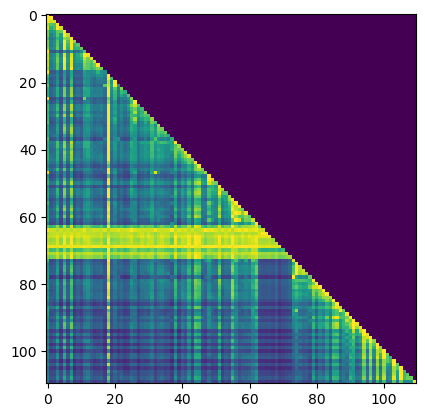

In [9]:
head_norm = heads.mean(axis=0)
head_norm = np.apply_along_axis(lambda x: x / np.max(x), 1, head_norm)
plt.imshow(head_norm, cmap="viridis")
plt.show()

Attention ignoriert die Akustik weitestgehend